In [7]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
from rosa import  predict


BASE_DIR = "/Users/nsofroniew/Documents/data/rosa/outputs/2023-02-12/21-58-13"
# BASE_DIR = "/Users/nsofroniew/Documents/data/rosa/outputs/2023-01-31/21-50-36"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    cfg = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = BASE_DIR + "/checkpoints/*.ckpt"
    chkpt = glob(chkpts)[1]

    adata = predict(cfg, chkpt)

display(adata)

/var/folders/6n/b_zkz2ns3_l02s3g4lnlklxr0000gq/T/ipykernel_58420/2725110195.py:11: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


RosaLightningModule(
  (model): RosaSingleModel(
    (main): Sequential(
      (layer_norm): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (input_embed): Identity()
      (feed_forward): Identity()
      (dropout): Dropout(p=0.5, inplace=False)
      (expression_head): ProjectionExpressionHead(
        (model): Sequential(
          (projection): Linear(in_features=3072, out_features=369, bias=True)
          (activation): Softplus(beta=1, threshold=20)
        )
      )
    )
  )
)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
Missing logger folder: /Users/nsofroniew/Documents/GitHub/rosa/notebooks/lightning_logs
/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

AnnData object with n_obs × n_vars = 369 × 19431
    obs: 'dataset_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'label', 'sample', 'n_genes', 'train', 'marker_gene', 'marker_feature_name'
    var: 'soma_joinid', 'feature_name', 'feature_length', 'column_1', 'column_2', 'column_3', 'column_4', 'external_gene_name', 'gene_biotype', 'train', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_label', 'hvg', 'log1p', 'obs_embedding_pca', 'preprocessing', 'rank_genes_groups', 'var_embedding_pca'
    obsm: 'bin_edges', 'embedding'
    varm: 'embedding', 'embedding_pca'
    layers: 'binned', 'counts', 'log1p', 'normalized_counts', 'prediction'

In [8]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))



        mean spearmanr across genes 0.713
        mean spearmanr across cells 0.423
        mean square error 0.614
        ks-statistic on total expression 0.254
        mean percent total expression captured per cell 31.673
        


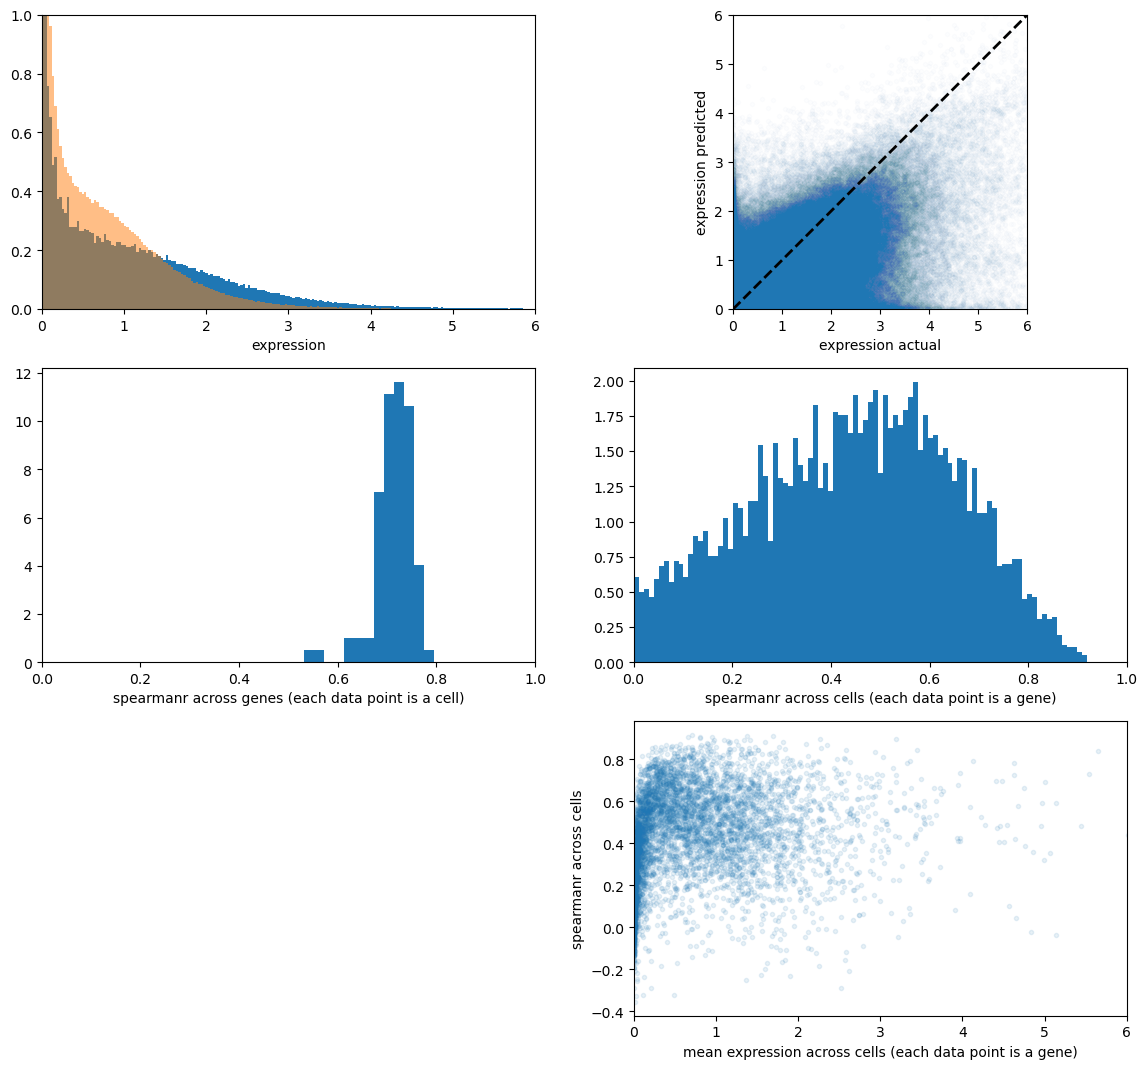

In [9]:
plot_expression_and_correlation(adata_test, results)

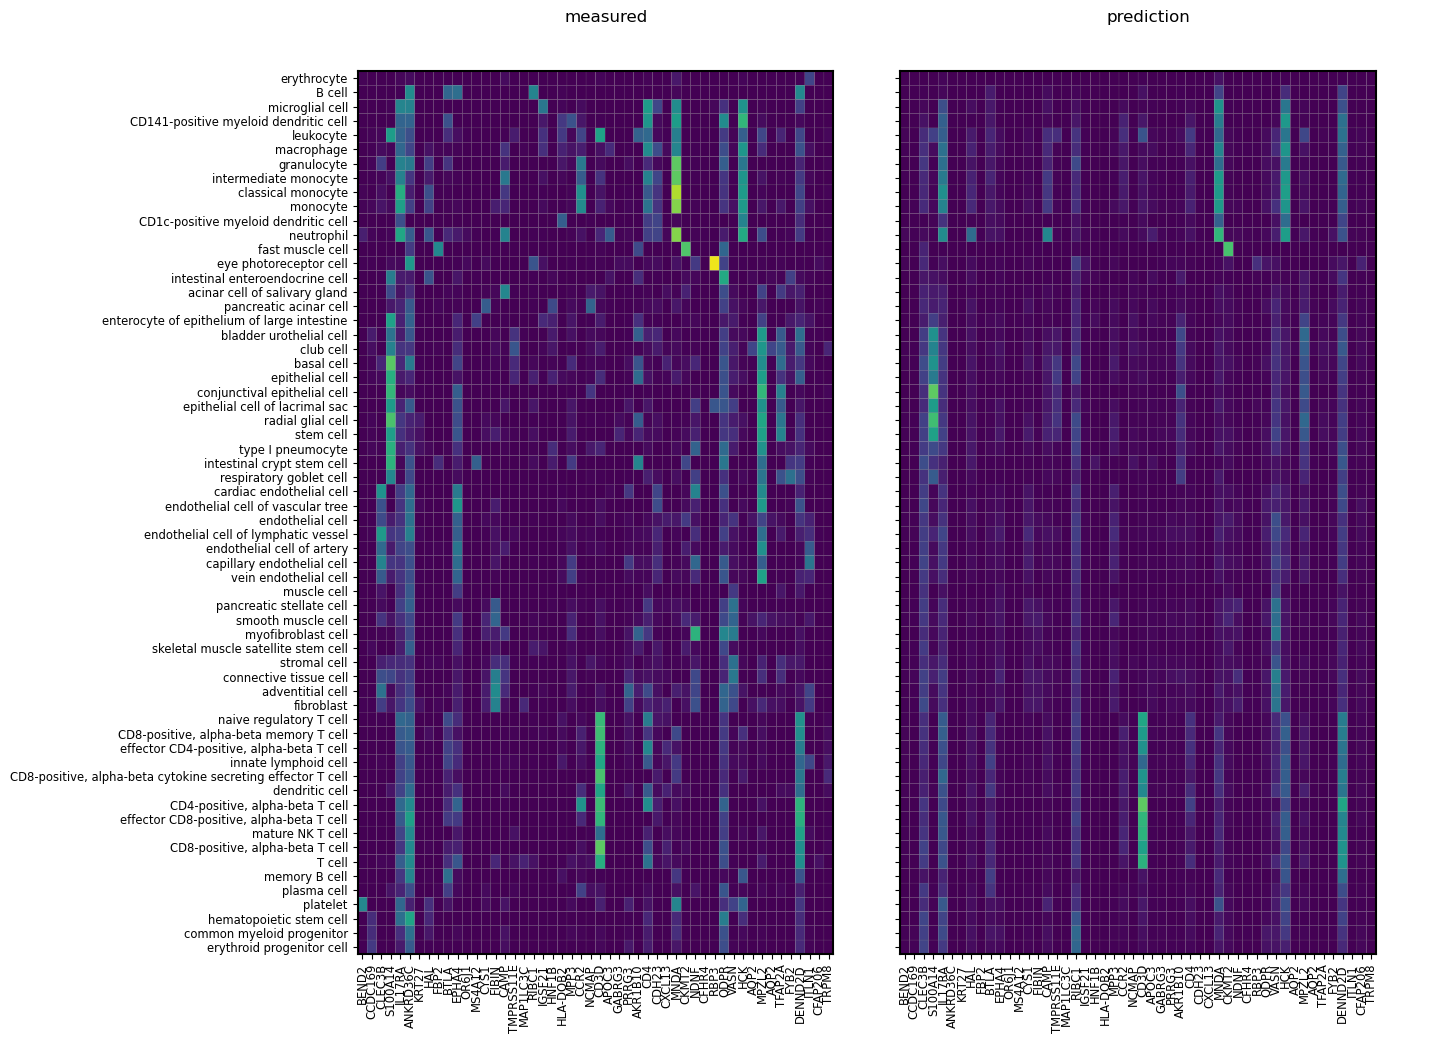

In [10]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

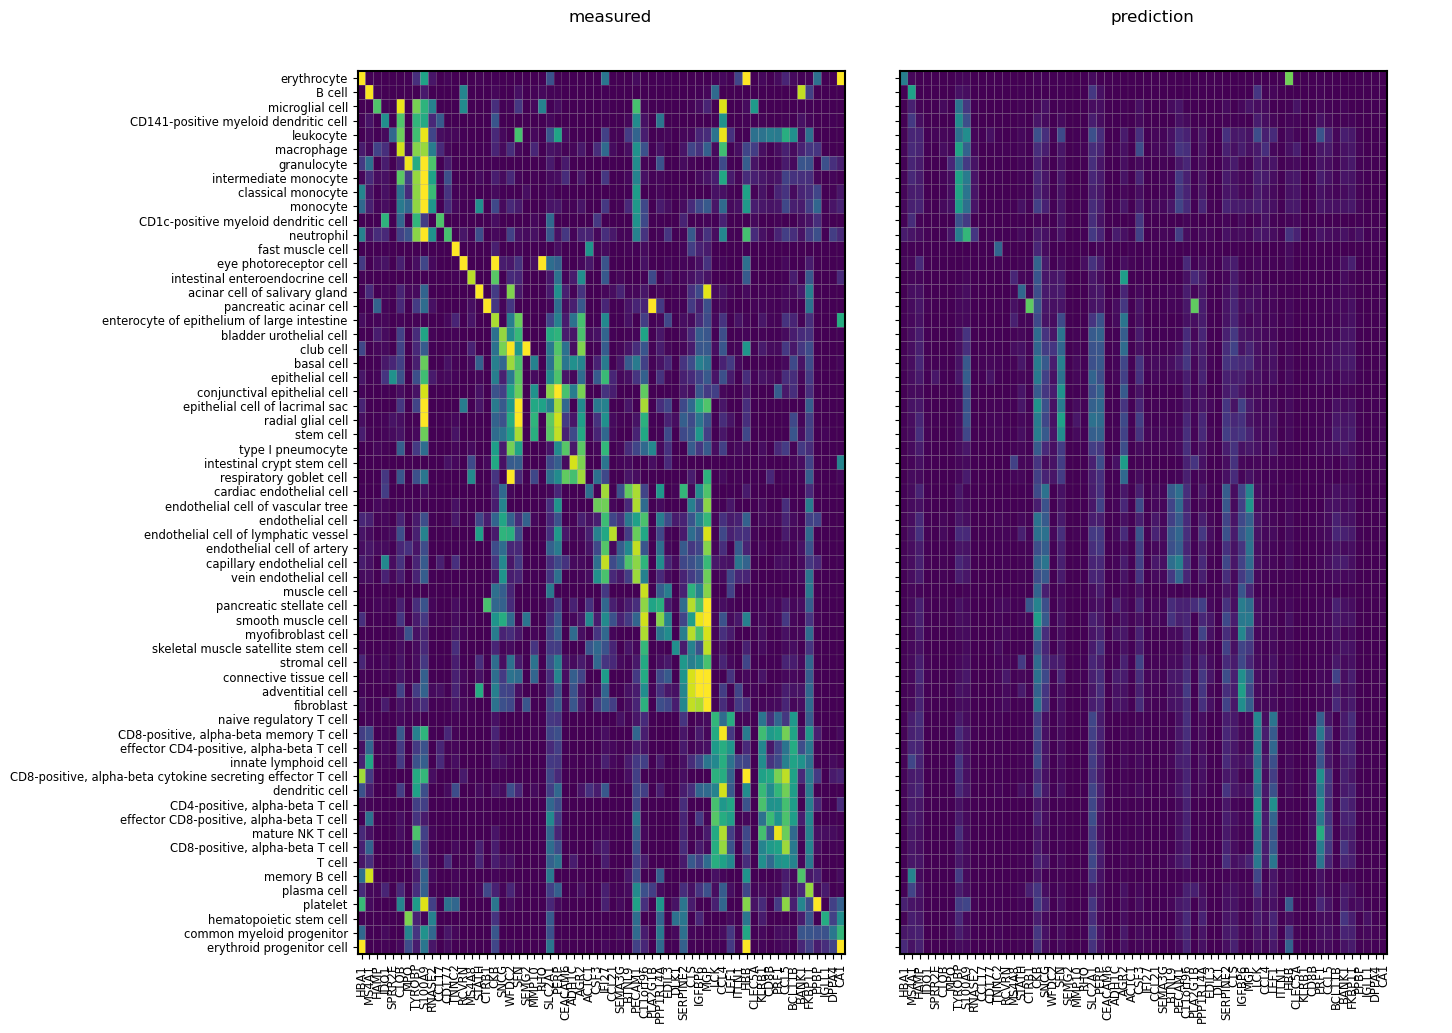

In [11]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)